In [96]:
#importing the necessary packages 
import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [97]:
base_dir = 'C:/Users/snehi/Documents/Projects_ML/state-farm-distracted-driver-detection/' # base directory
images_dir = os.path.join(base_dir,'imgs/')                   # images directory
test_dir = os.path.join(base_dir,'imgs/test/')                # test directory
train_dir = os.path.join(base_dir,'imgs/train/')              # train directory

driver_imgs_list = pd.read_csv(os.path.join(base_dir,'driver_imgs_list.csv'))  # images list csv 
sample_sub = pd.read_csv(os.path.join(base_dir,'sample_submission.csv'))     

In [98]:
# lets look the image details 
driver_imgs_list.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [99]:
# checking n unique classes avaliable 
classes = driver_imgs_list['classname'].unique()
classes

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

In [100]:
# keepsing some description for each class based on the driver position to have some clear idea 

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

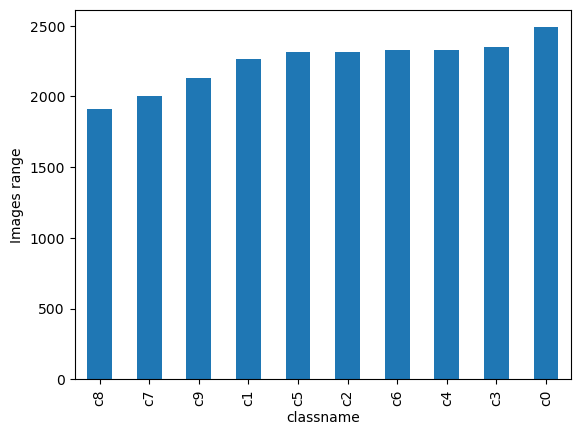

In [101]:
# lets check the class distribution 

driver_imgs_list.groupby('classname')['img'].count().sort_values().plot(kind='bar')
plt.ylabel('Images range')
plt.show()

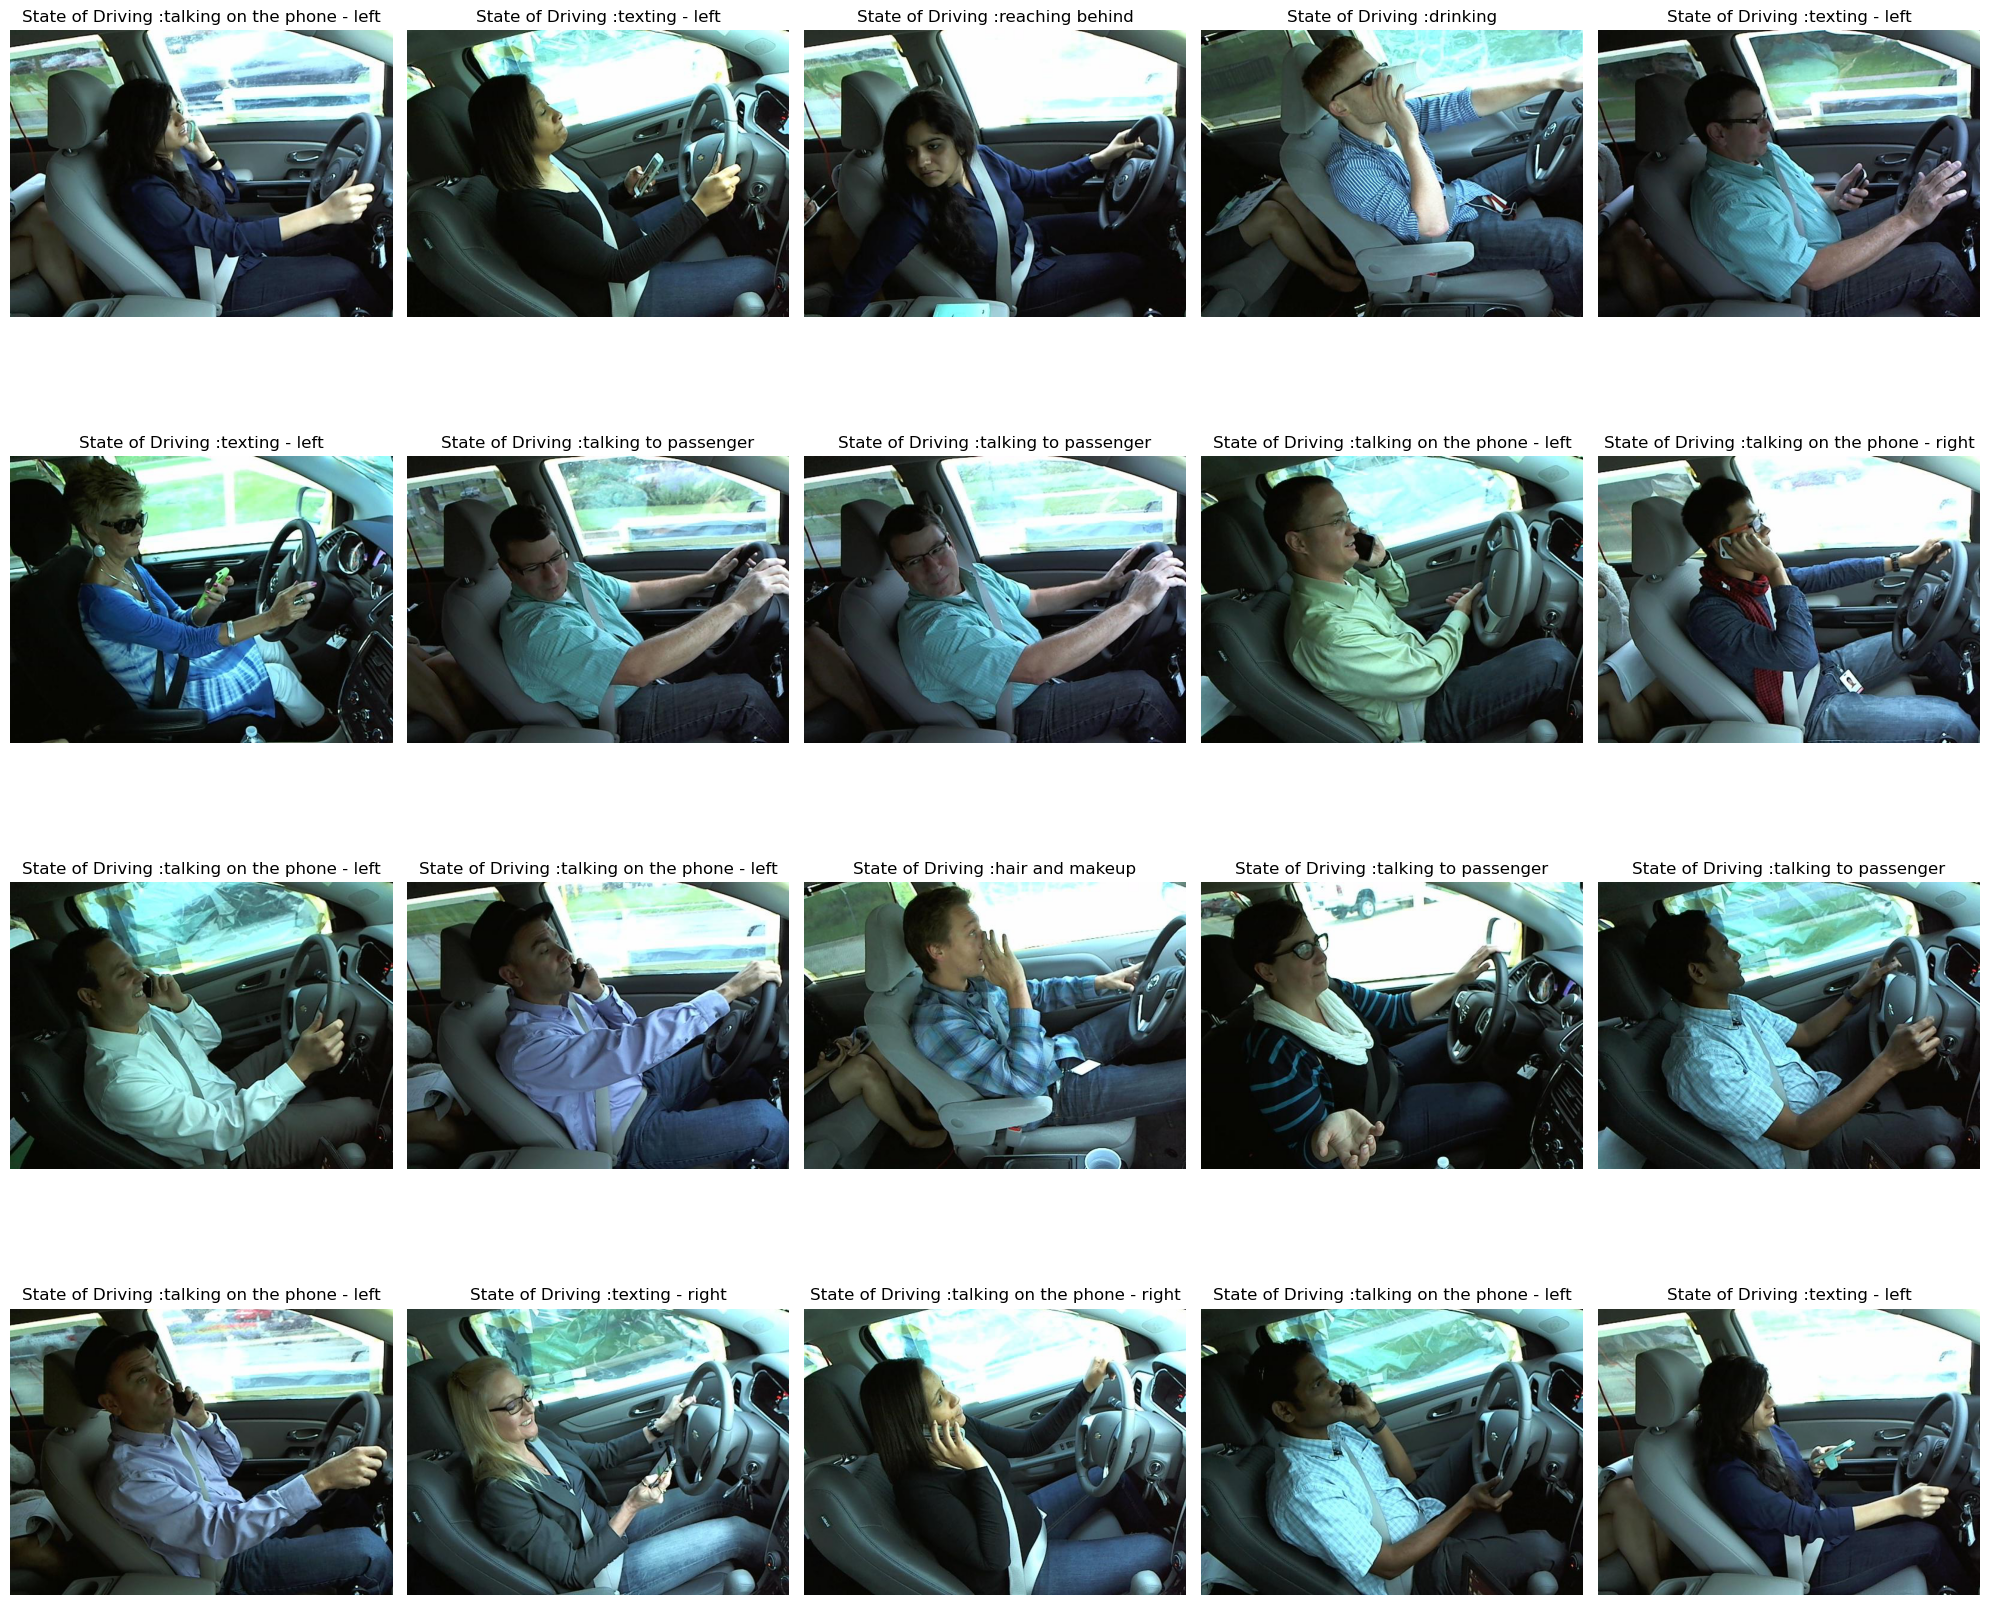

In [102]:
fig = plt.figure(figsize=(20,18)) # image size
cols,rows = 5,4                   

for i in range(1,cols*rows+1):
    pic_indx = random.randint(0,driver_imgs_list.shape[0])
    img = Image.open(os.path.join(base_dir,'imgs/train/')+str(driver_imgs_list.loc[pic_indx,'classname']+'/')
                    + str(driver_imgs_list.loc[pic_indx,'img']))
    fig.add_subplot(rows,cols,i)
    plt.imshow(img)
    plt.title('State of Driving :'+ class_def[driver_imgs_list.loc[pic_indx,'classname']])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [103]:
# creating the train data generator and test data generator
 
image_size = (128,128)  # image shape
batch_size = 32
val_size = 0.2

train_data_gen = ImageDataGenerator(rescale=1./255,validation_split= val_size)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [104]:
# defining the training parameters


train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = image_size,
                                                     batch_size = batch_size,
                                                     seed=42, 
                                                     shuffle=True,
                                                     subset='training')

val_generator =  train_data_gen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               batch_size = batch_size,
                                               seed=42, 
                                               shuffle=True,
                                               subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [105]:
# check the data for one batch

for data_batch,label_batch in train_generator:
    print(data_batch.shape)   # train batch
    print(label_batch.shape)  # label batch
    break

(32, 128, 128, 3)
(32, 10)


In [106]:
model = Sequential()                                                  # creating a sequential model
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3))) # taking units of 32 and filter of 3x3
model.add(MaxPooling2D(2,2))                                          # maxpool layer with 2x2 filter   
model.add(Conv2D(64,(3,3),activation='relu'))                         # taking units of 64 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))                        # taking units of 128 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu'))                        # taking units of 256 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(512,(3,3),activation='relu'))                        # taking units of 512 and filter of 3x3
model.add(MaxPooling2D(2,2))    
model.add(Flatten())                                                  # flattening the data to feed into to Dense layer
model.add(Dense(1024,activation='relu'))                              # taking units of 1024
model.add(Dense(512,activation='relu'))                               # taking units of 512 
model.add(Dense(128,activation='relu'))                               # taking units of 128
model.add(Dense(10,activation='softmax'))                             # output later with units of 10 since 10 labels

model.summary() # to print summary of model architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 128)     

In [107]:
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [108]:
epochs = 10
history = model.fit(train_generator,
         steps_per_epoch=240,
         epochs=epochs,
         validation_data=val_generator,
         validation_steps=60
        )

Epoch 1/10
240/240 [==============================] - 246s 1s/step - loss: 2.3012 - accuracy: 0.1005 - val_loss: 2.3003 - val_accuracy: 0.1000
Epoch 2/10
240/240 [==============================] - 274s 1s/step - loss: 1.9622 - accuracy: 0.2260 - val_loss: 1.0542 - val_accuracy: 0.6036
Epoch 3/10
240/240 [==============================] - 269s 1s/step - loss: 0.6760 - accuracy: 0.7566 - val_loss: 0.4205 - val_accuracy: 0.8526
Epoch 4/10
240/240 [==============================] - 268s 1s/step - loss: 0.3105 - accuracy: 0.9022 - val_loss: 0.2236 - val_accuracy: 0.9276
Epoch 5/10
240/240 [==============================] - 291s 1s/step - loss: 0.1978 - accuracy: 0.9367 - val_loss: 0.1923 - val_accuracy: 0.9391
Epoch 6/10
240/240 [==============================] - 305s 1s/step - loss: 0.1185 - accuracy: 0.9654 - val_loss: 0.1458 - val_accuracy: 0.9599
Epoch 7/10
240/240 [==============================] - 304s 1s/step - loss: 0.1099 - accuracy: 0.9663 - val_loss: 0.1415 - val_accuracy: 0.9563

In [109]:
model.save('distracted_driver.h5')

In [110]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

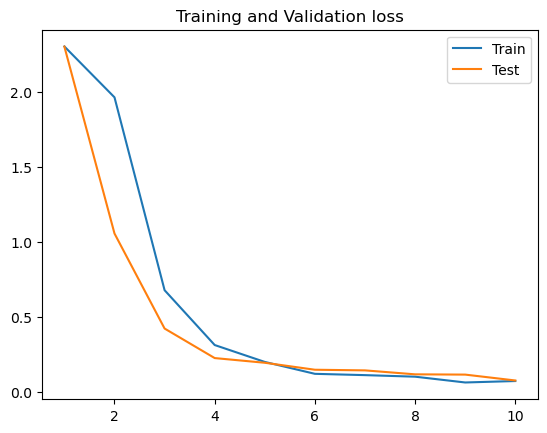

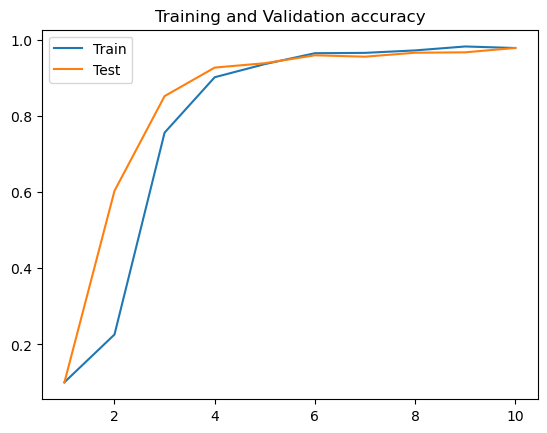

In [111]:
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

In [112]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    images_dir,
    shuffle = False,
    target_size = image_size,
    classes = ['test'],
    batch_size = 32
)

Found 74677 images belonging to 1 classes.


In [113]:
preds = model.predict(test_data)

2334/2334 [==============================] - 939s 402ms/step


In [122]:
preds

array([[8.3956519e-07, 4.8506615e-10, 3.9871661e-06, ..., 2.1513558e-06,
        5.2814295e-07, 4.3346536e-06],
       [8.4442372e-06, 6.3316641e-08, 1.8187684e-05, ..., 1.9668068e-05,
        2.8310018e-04, 4.3496420e-05],
       [5.8822387e-01, 2.1990584e-01, 7.1993790e-04, ..., 2.4344616e-03,
        2.7930962e-02, 1.1332083e-01],
       ...,
       [2.8257218e-01, 1.2218329e-02, 1.3455641e-03, ..., 9.0143143e-04,
        5.8528140e-02, 1.2876771e-02],
       [6.8167428e-05, 3.3200744e-05, 9.6321404e-02, ..., 7.1641110e-04,
        3.6459252e-01, 4.9015912e-03],
       [3.3427716e-07, 1.3204775e-10, 5.9694862e-09, ..., 2.2925964e-07,
        1.6556388e-06, 1.4019175e-03]], dtype=float32)

In [119]:
test_imgs = os.path.join(base_dir, 'imgs/test')
test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
for i in range(len(preds)):
    pred_df.loc[i,'img'] = test_ids[i]
    pred_df.loc[i , 'c0':'c9'] = preds[i]

In [120]:
pred_df

img        c0        c1        c2        c3        c4  \
0           img_1.jpg  0.000001       0.0  0.000004       0.0       0.0   
1          img_10.jpg  0.000008       0.0  0.000018       0.0  0.000001   
2         img_100.jpg  0.588224  0.219906   0.00072  0.009717  0.006151   
3        img_1000.jpg  0.007054  0.034591  0.008641   0.01126  0.060592   
4      img_100000.jpg  0.000635  0.000048       0.0   0.99492  0.001255   
...               ...       ...       ...       ...       ...       ...   
74672   img_99994.jpg  0.017671  0.383656  0.012003  0.001768  0.006585   
74673   img_99995.jpg  0.000344  0.000129       0.0  0.999288  0.000063   
74674   img_99996.jpg  0.282572  0.012218  0.001346  0.109262  0.477841   
74675   img_99998.jpg  0.000068  0.000033  0.096321   0.00001   0.00028   
74676   img_99999.jpg       0.0       0.0       0.0       0.0       0.0   

             c5        c6        c7        c8        c9  
0      0.999988       0.0  0.000002  0.000001  0.000004  
1      0.999624  0.000002   0.00002  0.000283  0.000043  
2      0.031277  0.000319  0.002434  0.027931  0.113321  
3      0.006544  0.320569  0.001442  0.532476  0.016833  
4      0.000396  0.000009  0.000002  0.002705  0.000029  
...         ...       ...       ...       ...       ...  
74672    0.0025  0.044206  0.034404   0.42211  0.075098  
74673  0.000009       0.0       0.0  0.000161  0.000006  
74674  0.040968  0.003487  0.000901  0.058528  0.012877  
74675  0.000399  0.532678  0.000716  0.364593  0.004902  
74676  0.998596       0.0       0.0  0.000002  0.001402  

[74677 rows x 11 columns]